# Data setup 

In [ ]:
# initialize data 
###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name):
    #case = 1-> Id from file. Iq in 0->220 > 'i_direct_flux'
    #case = 2 -> Iq from file. Id in 0->220 > 'j_q_flux'
    data = np.loadtxt(file_name, delimiter=',')
    alfa = list(range(0,31))
    I_currents = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6]
    xLabel = " I [A]"
    yLabel = "Flux"
    return alfa, np.transpose(data), I_currents, xLabel, yLabel
    
alfa, Flux, I_currents, xLabel, yLabel = data_from_file('SRM_measurements/SRM.txt')

print('alfa', alfa)
print('currents', I_currents)
print('flux', Flux.shape)

# [REDUCE CURRENTS] Represent original curves for different angles values

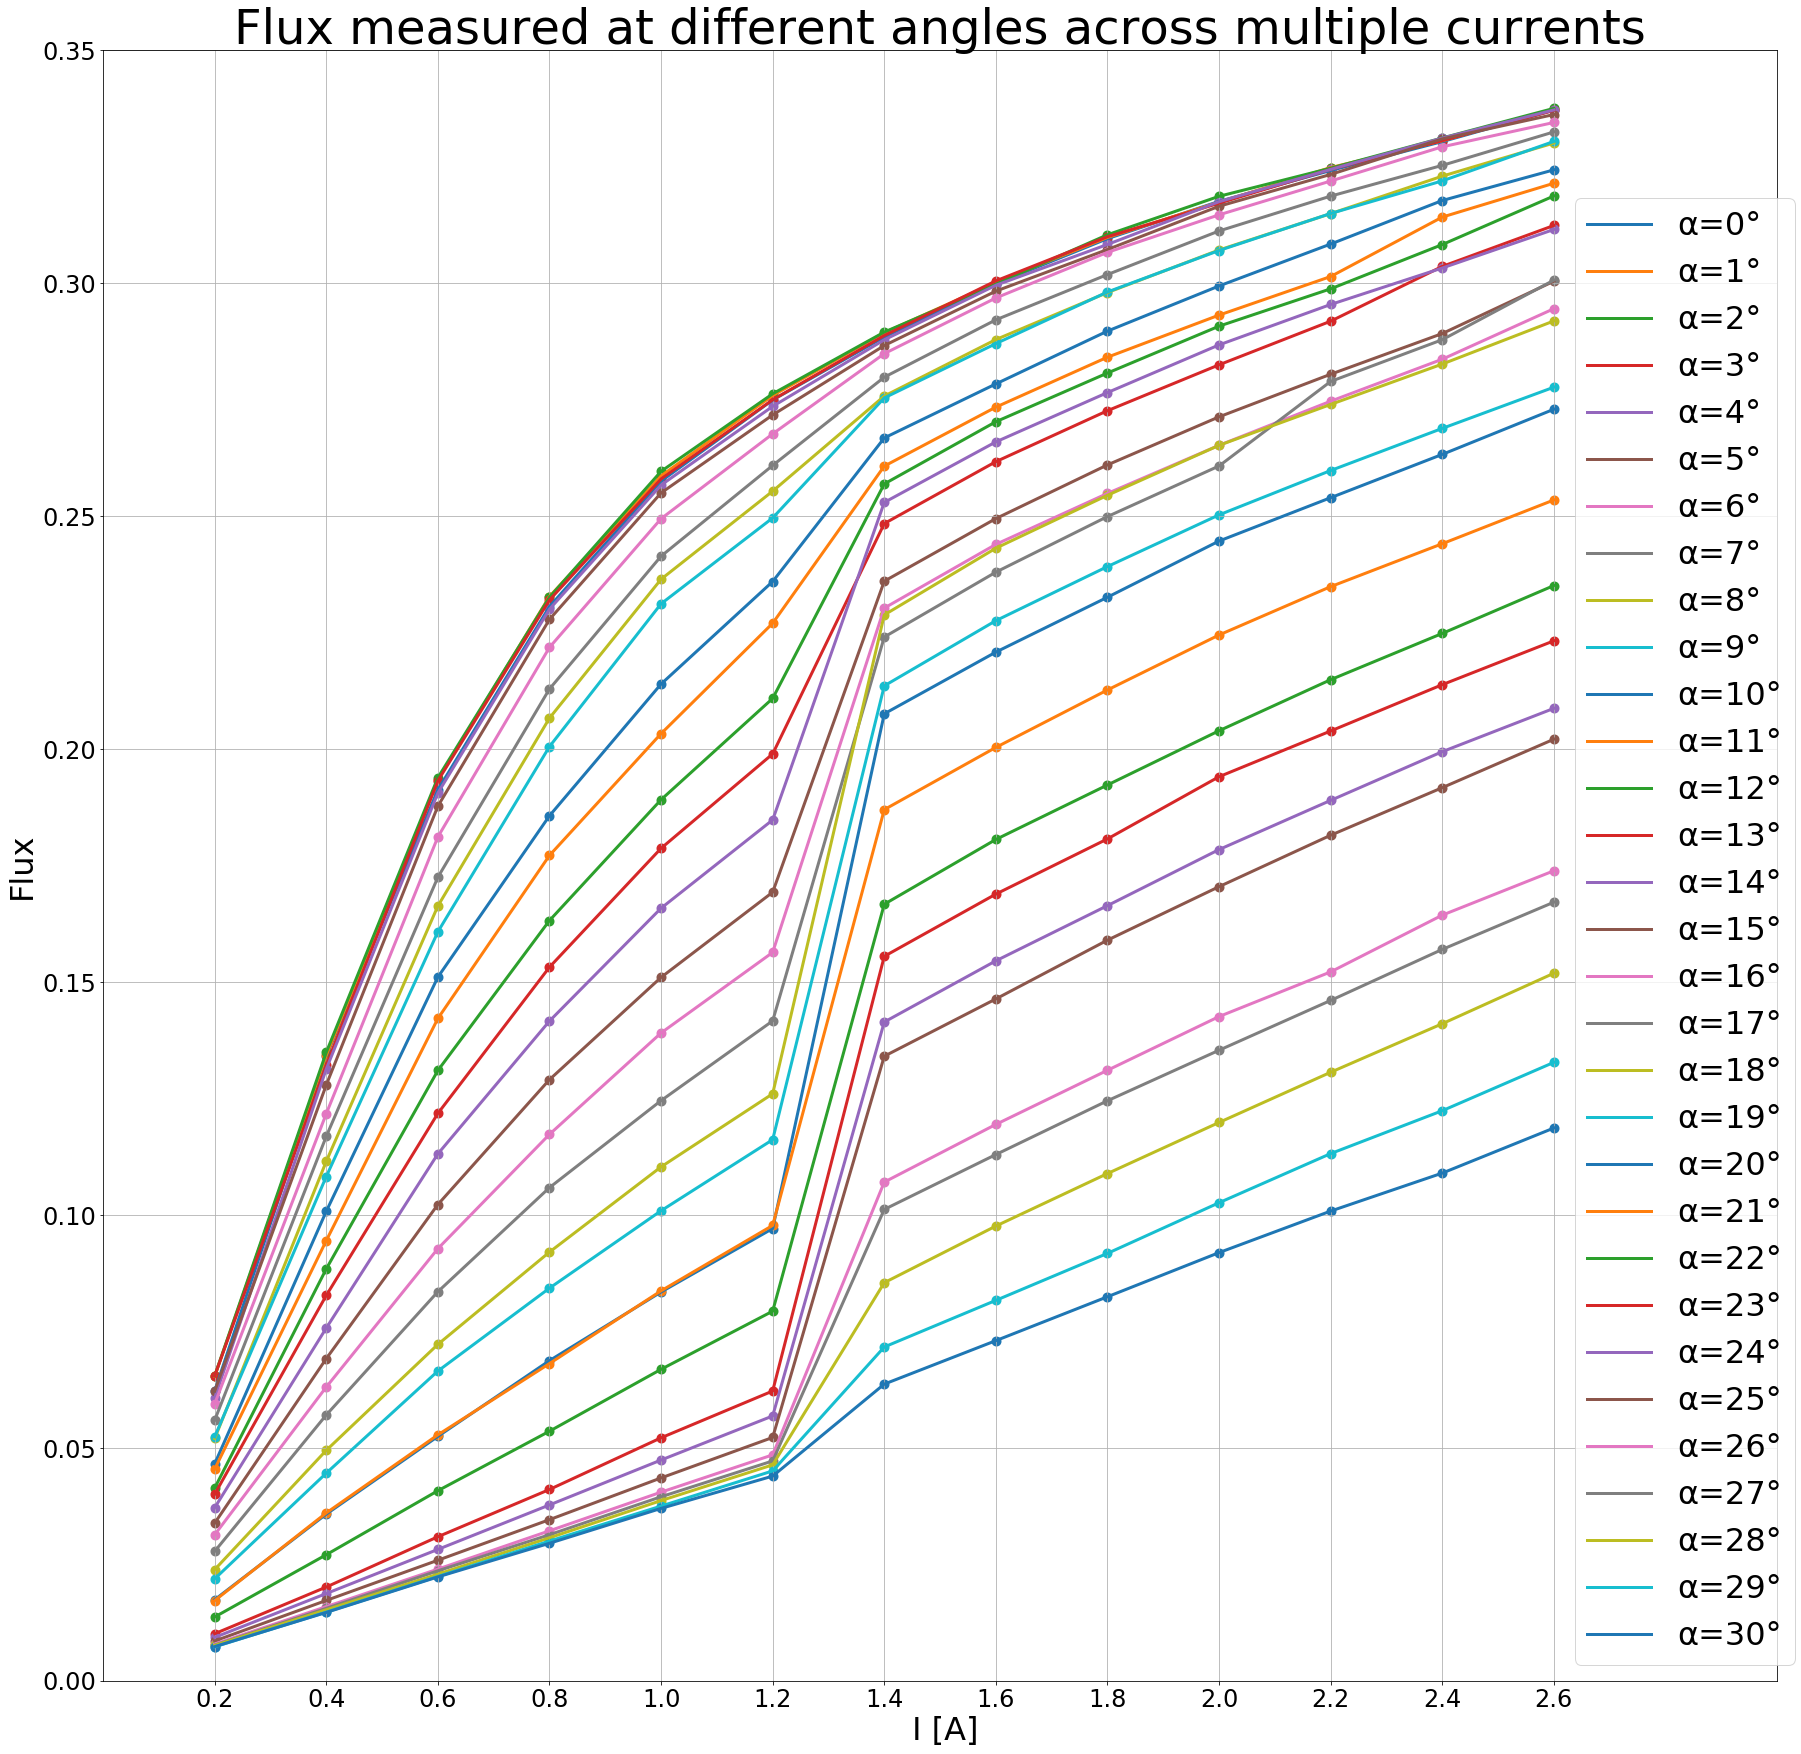

In [3]:
from subprocess import call

flux = np.copy(Flux)

plt.figure(figsize=[30,30])

for idx in alfa:
    df =flux[idx, :]
    plt.plot(I_currents, df, linewidth=3, label='α=%d°' %(idx))
    plt.scatter(I_currents,df, linewidths=4)
    plt.ylim([0,0.35])
    plt.xlim([0, 3])
    plt.xticks(I_currents, fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(xLabel, fontsize = 32)
    plt.ylabel(yLabel, fontsize = 32)
    plt.title('Flux measured at different angles across multiple currents', fontsize=48)
    plt.legend(bbox_to_anchor=(1.02, 0), loc='lower right', ncol=1, fontsize=32)
plt.grid()
plt.savefig('SRM_output/SRM_curves_flux.png', dpi = 200)
plt.show()

# [REDUCE CURRENTS] Use PCA to reduce the number of Ox points (curents)

- observed variable: flux at a specific curent

- sample: given an angle, measure flux value for different currents; we are oblivious of the angle under which the measurement was made; this descripition indicates only how all the samples were collected

- X.shape: (angles, currents)

- what we want: determine curents with highest variance (this what PCA does) across all grades



# [REDUCE CURRENTS] Plot reconstruction error of PCA as a function of different number of components

components shape:  (13, 13)


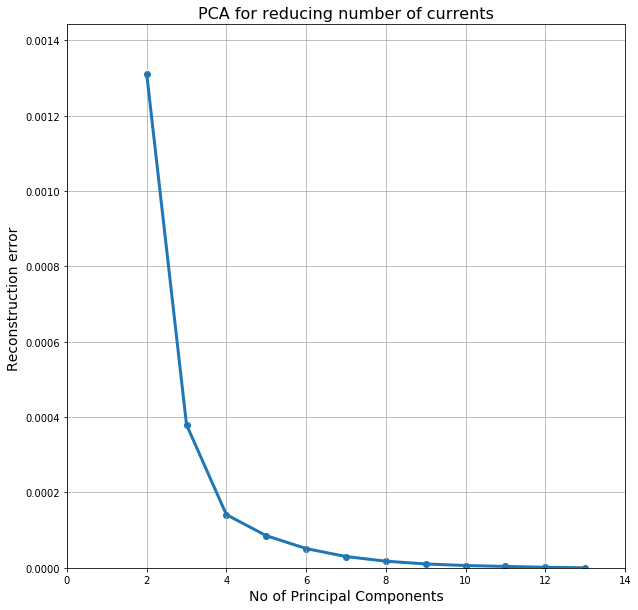

In [4]:
#
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing

#preprocess the data
X = np.copy(Flux)
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)
no_of_comps = range(2, 14)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - X) ** 2))
print('components shape: ', pca_reduce_points.components_.shape)

plt.figure(figsize=(10, 10))
plt.xlabel('No of Principal Components', fontsize = 14)
plt.ylabel('Reconstruction error ', fontsize = 14)
plt.xlim([0,14])
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors)
plt.plot(no_of_comps, errors, linewidth=3)
plt.grid()
plt.title('PCA for reducing number of currents', fontsize=16)
plt.savefig('SRM_output/errors_PCA_reducing_#curents.png', dpi = 200)
plt.show()



# [REDUCE CURRENTS] Find currents with highest variance and choose top n
- Alegem sa zicem 6. Stim din plotul de mai sus ca 6 curenti ne dau eroare de reconstructie suficienta
- Am avut nevoie de PCA ca sa imi aleg n, avand o imagine despre cat o sa pierd

In [5]:
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = np.copy(Flux)
variance = np.var(X, axis=0)

currents_variance = sorted(zip(I_currents, variance), key=lambda e : e[1], reverse=True)
border_currents = [e for e in currents_variance if e[0] == min(I_currents)] + [e for e in currents_variance if e[0] == max(I_currents)]
non_border_currents = [e for e in currents_variance if e not in border_currents]

def get_top_currents(currents_no):
    top_currents = sorted([e[0] for e in currents_variance[:currents_no]])
    return top_currents

def get_top_currents_bordered(currents_no):
    assert(currents_no >= 2)
    top_currents = border_currents + non_border_currents[:currents_no-2]
    return sorted([e[0] for e in top_currents])

top_n = range(2, len(I_currents))

print('CURRENTS WITH HIGHEST VARIANCE')
for n in top_n:
    top_n_curents = get_top_currents(n)
    print('top %2d currents' % n, top_n_curents)
print('\n')

print('CURRENTS WITH HIGHEST VARIANCE -- always including max/min (0.2, 2.6) -- because spline needs limit values')
for n in top_n:
    top_n_curents = get_top_currents_bordered(n)
    print('top %2d currents' % n, top_n_curents)


CURRENTS WITH HIGHEST VARIANCE
top  2 currents [1.0, 1.2]
top  3 currents [0.8, 1.0, 1.2]
top  4 currents [0.8, 1.0, 1.2, 1.6]
top  5 currents [0.8, 1.0, 1.2, 1.4, 1.6]
top  6 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
top  7 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
top  8 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
top  9 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
top 10 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
top 11 currents [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
top 12 currents [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]


CURRENTS WITH HIGHEST VARIANCE -- always including max/min (0.2, 2.6) -- because spline needs limit values
top  2 currents [0.2, 2.6]
top  3 currents [0.2, 1.2, 2.6]
top  4 currents [0.2, 1.0, 1.2, 2.6]
top  5 currents [0.2, 0.8, 1.0, 1.2, 2.6]
top  6 currents [0.2, 0.8, 1.0, 1.2, 1.6, 2.6]
top  7 currents [0.2, 0.8, 1.0, 1.2, 1.4, 1.6, 2.6]
top  8 currents [0.2, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8,

## [REDUCE CURRENTS] We measure the flux value in key top n curents and then use linear interpolation to predict flux across all curents -- Vezi ca am schimbat de la cubic spline la linear pt ca merge mai bine. Justificarea e ca ai treapta aia, are shape mai degraba in trepte decat in curbe.
- plot Interpolation error as a function of the number of points used as basis per each curve
- we expect to get the same shape like in PCA reconstruction (first plot)

(31, 13)
COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS


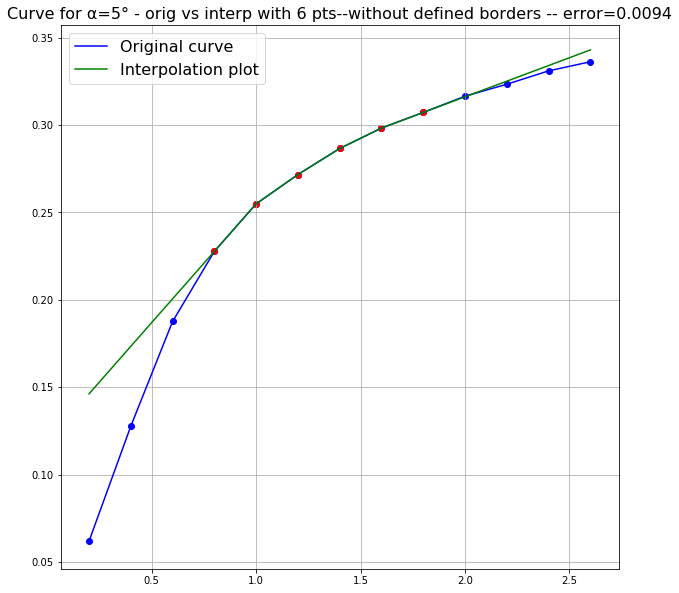

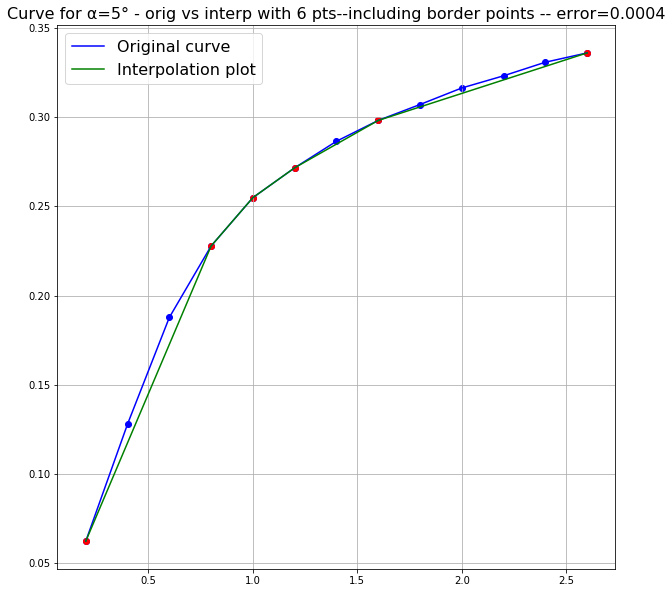

COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis


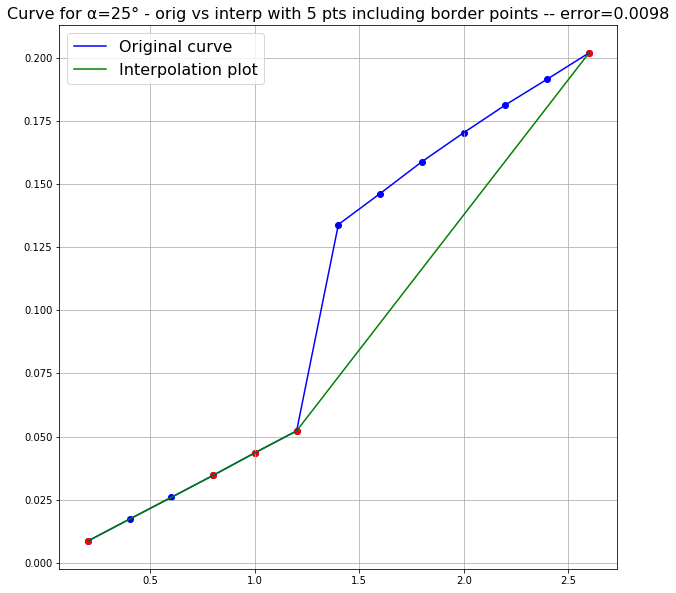

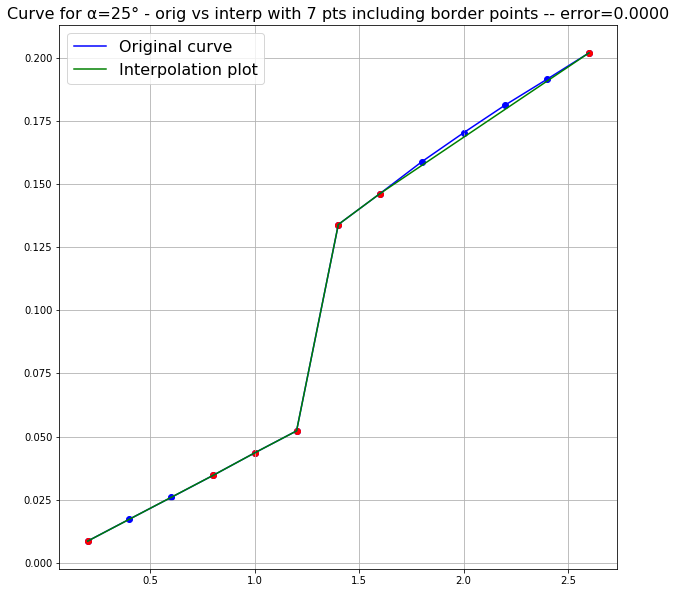

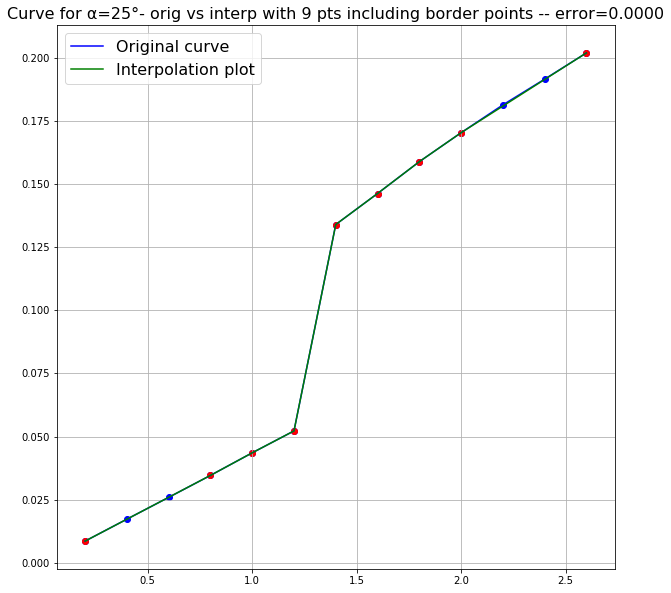

2.6190896788421553e-07

In [6]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

X = np.copy(Flux)
print(X.shape)

def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

def compare_curve_with_interp(curve, n, top_n_function, title):
    top_n_curents = top_n_function(n)
    top_n_curents_indices = [get_index(I_currents, c) for c in top_n_curents]
    plt.figure(figsize=(10, 10))
    x = I_currents 
    baseline = X[curve, :] 
    plt.plot(x, baseline, c='b', label = 'Original curve')
    plt.scatter(x, baseline, c='b')
    x_ = top_n_curents
    y_ = X[curve, top_n_curents_indices]
    tck_ = interpolate.splrep(x_, y_, k=1)
    y = interpolate.splev(x, tck_) 
    error = np.sum((y - baseline)**2)
    plt.scatter(x_, y_, c='r')
    plt.plot(x, y, c='g', label = 'Interpolation plot')
    plt.title('%s -- error=%.4f' % (title, error), fontsize=16)
    plt.legend(loc='best', fontsize = 16)
    plt.grid()
    plt.show()
    return error

print('COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS')
n = 6
curve = 5
compare_curve_with_interp(curve, n, get_top_currents, 
                                       'Curve for α=%d° - orig vs interp with %d pts--without defined borders' % (curve, n))
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                                       'Curve for α=%d° - orig vs interp with %d pts--including border points' % (curve, n))


print('COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis')
n = 5
curve = 25
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                                       'Curve for α=%d° - orig vs interp with %d pts including border points' % (curve, n))
n = 7
curve = 25
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                                       'Curve for α=%d° - orig vs interp with %d pts including border points' % (curve, n))
n = 9
curve = 25
compare_curve_with_interp(curve, n, get_top_currents_bordered, 
                                       'Curve for α=%d°- orig vs interp with %d pts including border points' % (curve, n))


(31, 13)


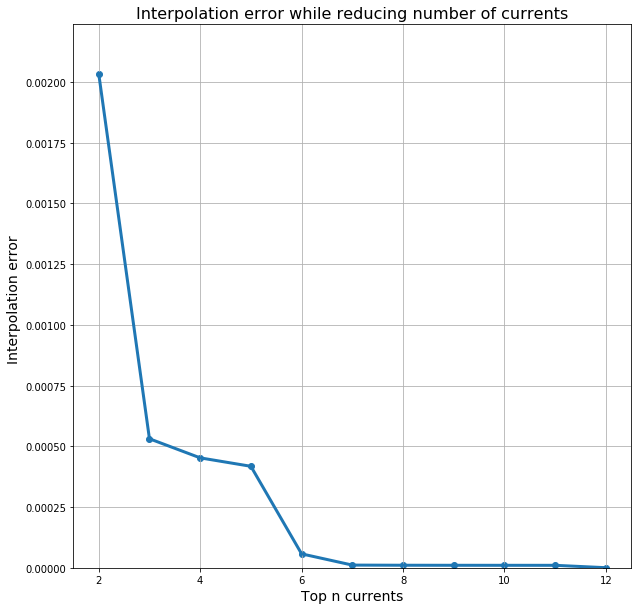

In [7]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

X = np.copy(Flux)
print(X.shape)

top_n = range(2, len(I_currents))
errors = []
for n in top_n:
    top_n_curents = get_top_currents_bordered(n)
    top_n_curents_indices = [get_index(I_currents, c) for c in top_n_curents]
    error = 0
    for curve in range(X.shape[0]):
        # baseline = y values obtained when interpolating with all ground truth points
        x = I_currents 
        baseline = X[curve, :] 

        # interpolate with top_n_currents as basis 
        x_ = top_n_curents
        y_ = X[curve, top_n_curents_indices]
        tck_ = interpolate.splrep(x_, y_, k=1)
        y = interpolate.splev(x, tck_) 
        
        # error -- difference between baseline interp curve and current one
        error += np.sum((baseline - y)**2) /  baseline.shape[0]
    errors.append(error / X.shape[0])
            
plt.figure(figsize=(10, 10))
plt.xlabel('Top n currents', fontsize = 14)
plt.ylabel('Interpolation error ', fontsize = 14)
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(top_n))
plt.scatter(top_n, errors)
plt.plot(top_n, errors, linewidth=3)
plt.grid()
plt.title('Interpolation error while reducing number of currents', fontsize=16)
plt.savefig('SRM_output/errors_interpolation_reducing_#curents.png', dpi = 200)
plt.show()


# Reducing the number of curves - alfa
- fix aceeasi logica ca mai sus dar transpui inputul

- vezi mai jos ce inseamna un sample

# [REDUCE ANGLES] Represent original curves 

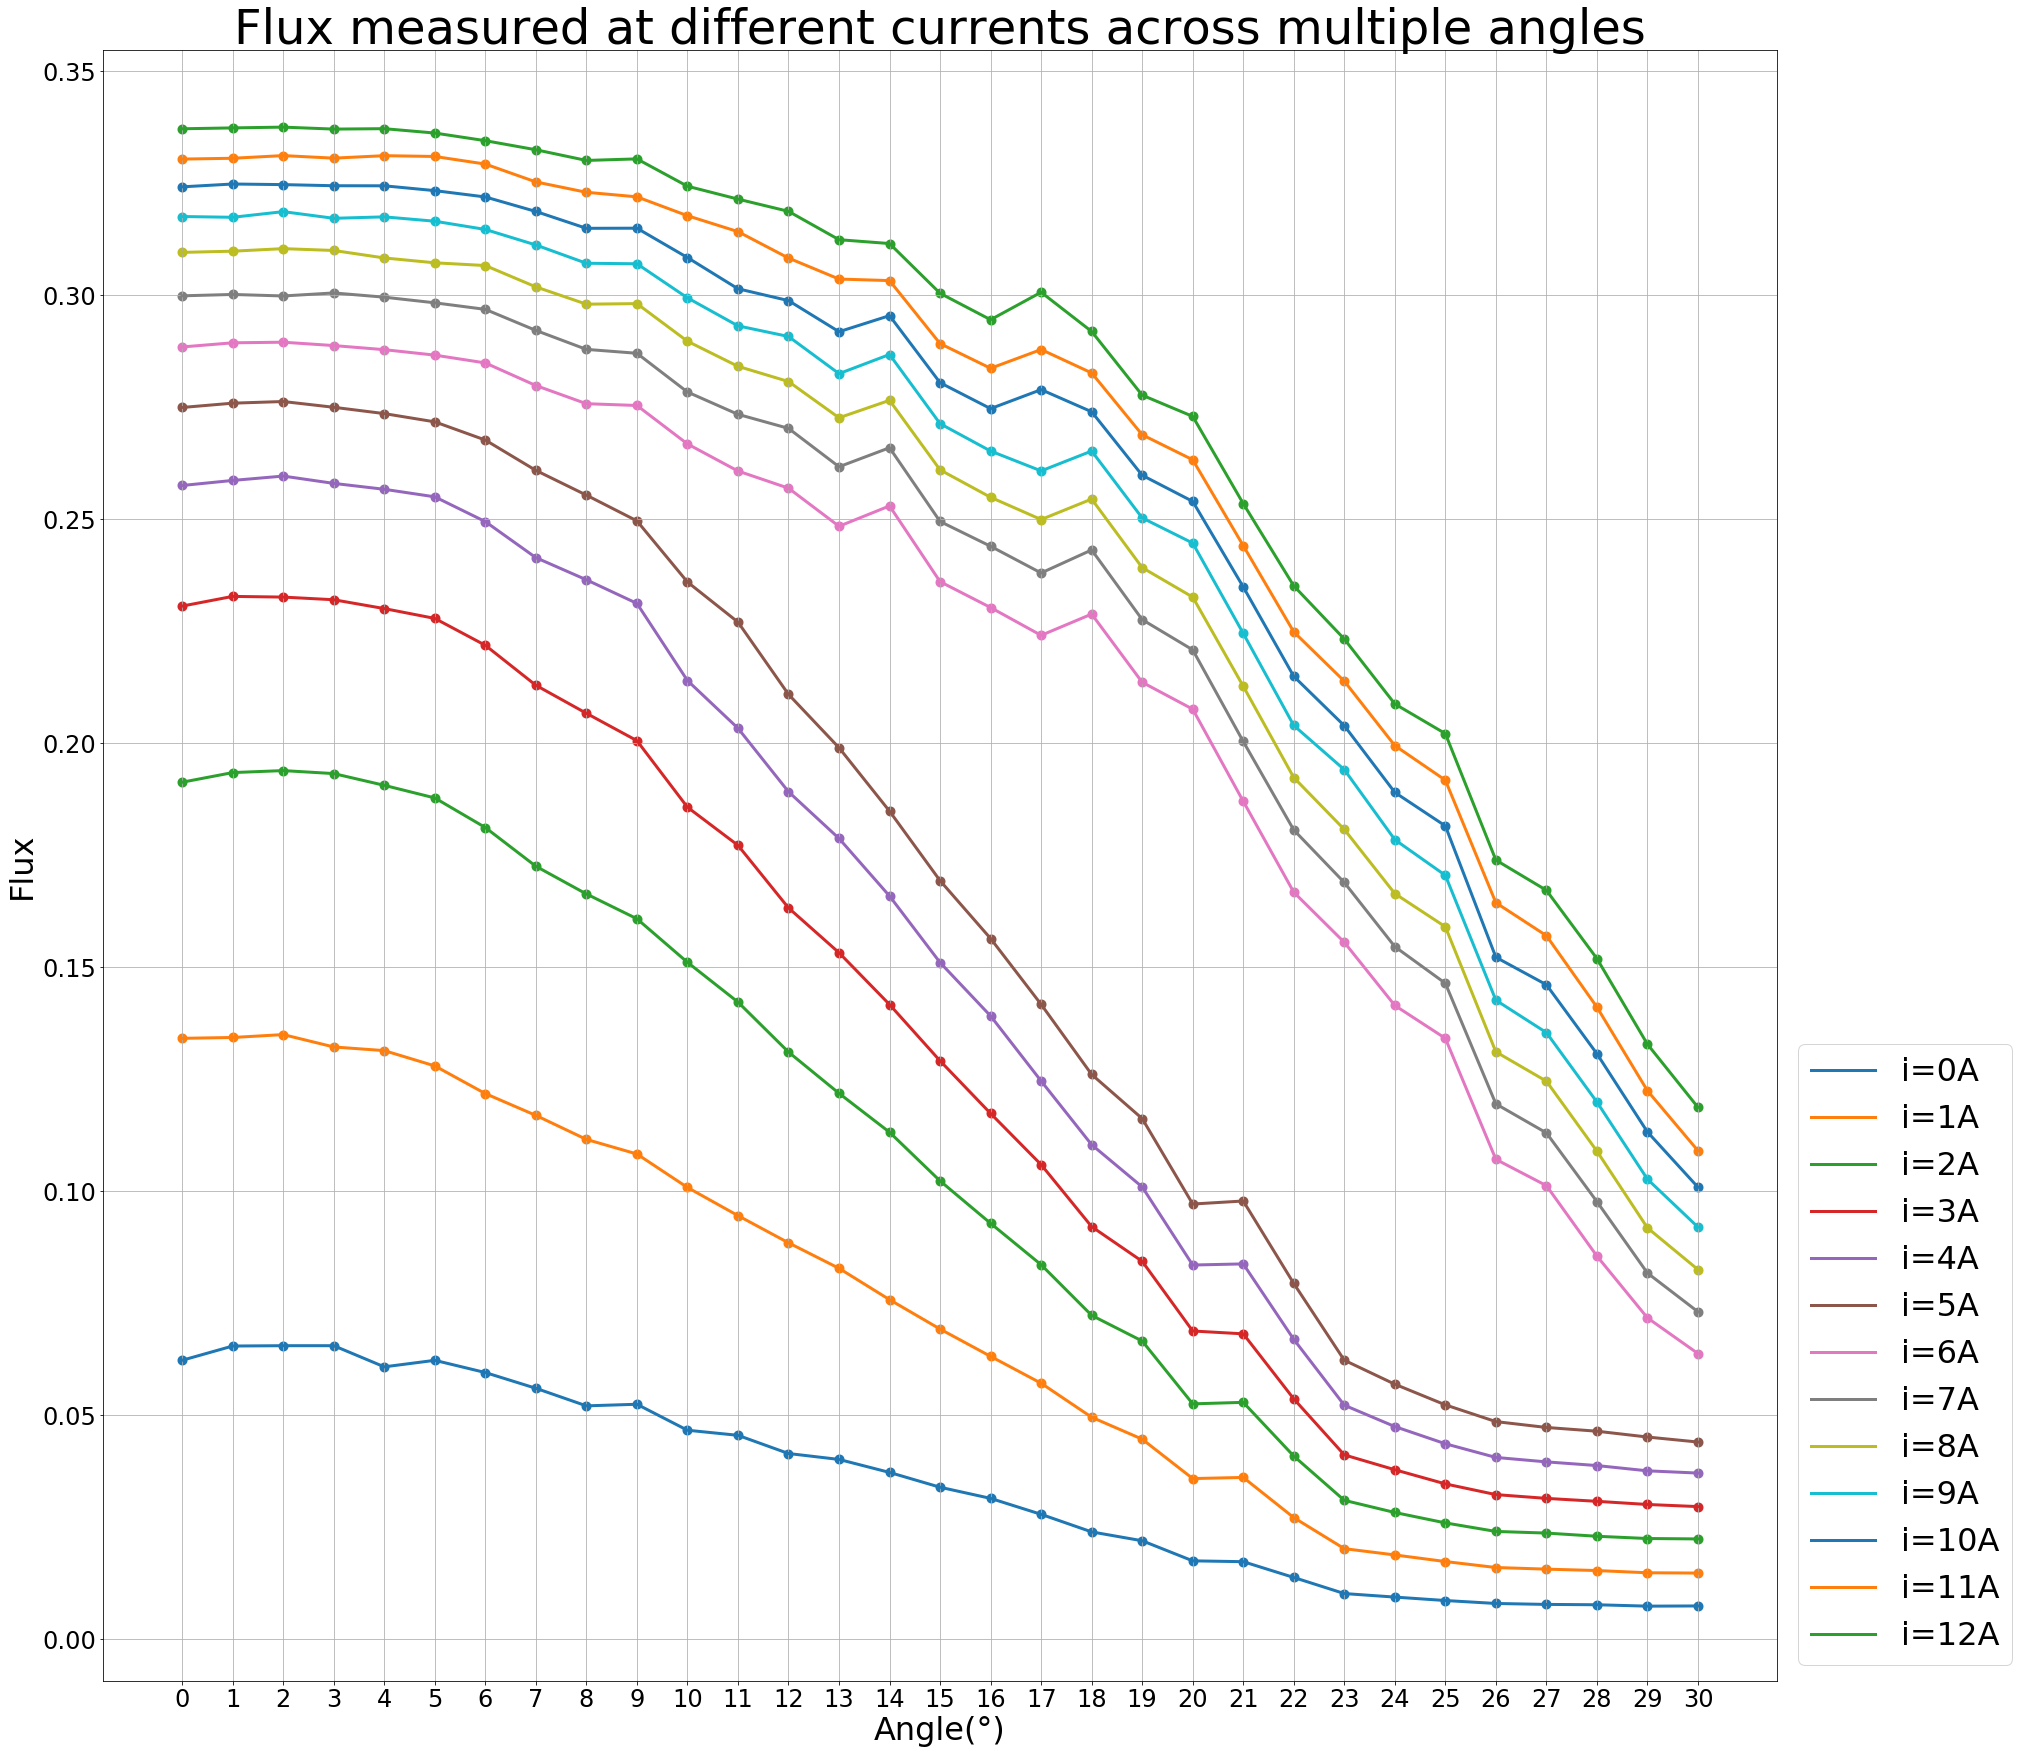

In [8]:
from subprocess import call

flux = np.transpose(np.copy(Flux))

plt.figure(figsize=[30,30])

for idx, current  in enumerate(I_currents):
    df =flux[idx, :]
    plt.plot(alfa, df, linewidth=3, label='i=%dA' %(idx))
    plt.scatter(alfa, df, linewidths=4)
#     plt.ylim([0,0.35])
#     plt.xlim([0, 3])
    plt.xticks(alfa, fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("Angle(°)", fontsize = 32)
    plt.ylabel(yLabel, fontsize = 32)
    plt.title('Flux measured at different currents across multiple angles', fontsize=48)
    plt.legend(bbox_to_anchor=(1.15, 0), loc='lower right', ncol=1, fontsize=32)
plt.grid()
plt.savefig('SRM_output/SRM_curves_currents.png', dpi = 300)
plt.show()

# [REDUCE ANGLES] Use PCA to reduce the number of Ox points (curents)

- observed variable: flux at a specific angle 

- sample: given a current, measure flux value at different angles; we are oblivious of the current under which the measurement was made; this descripition indicates only how all the samples were collected

- X.shape: (currents, angles)

- what we want: determine angles with highest variance (this what PCA does) across all currents



# [REDUCE ANGLES] Plot reconstruction error of PCA as a function of different number of components

components shape (13, 31)


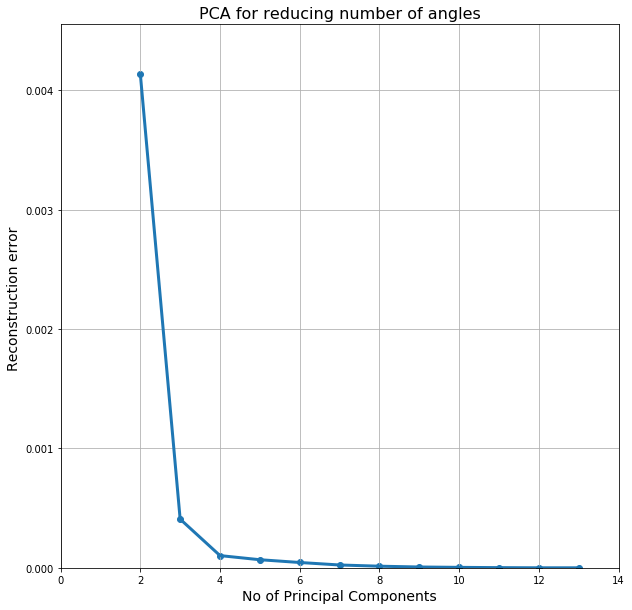

In [9]:
#
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing

#preprocess the data
X = np.transpose(np.copy(Flux))
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)

no_of_comps = range(2, 14)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - X) ** 2))
print('components shape', pca_reduce_points.components_.shape)

plt.figure(figsize=(10, 10))
plt.xlabel('No of Principal Components', fontsize = 14)
plt.ylabel('Reconstruction error ', fontsize = 14)
plt.xlim([0,14])
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors)
plt.plot(no_of_comps, errors, linewidth=3)
plt.grid()
plt.title('PCA for reducing number of angles', fontsize=16)
plt.savefig('SRM_output/errors_PCA_reducing_#angles.png', dpi = 200)
plt.show()


# [REDUCE ANGLES] Find angles with highest variance and choose top n
- Alegem sa zicem 6. tu stii din plotul de mai sus ca 6 unghiuri iti dau eroare de reconstructie suficienta
- Am avut nevoie de PCA ca sa imi aleg n, avand o imagine despre cat o sa pierd

In [10]:
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = np.transpose(np.copy(Flux))
variance = np.var(X, axis=0)

angles_variance = sorted(zip(alfa, variance), key=lambda e : e[1], reverse=True)
border_angles = [e for e in angles_variance if e[0] == min(alfa)] + [e for e in angles_variance if e[0] == max(alfa)]
non_border_angles = [e for e in angles_variance if e not in border_currents]

def get_top_angles(angles_no):
    top_angles = sorted([e[0] for e in angles_variance[:angles_no]])
    return top_angles

def get_top_angles_bordered(angles_no):
    assert(angles_no >= 2)
    top_angles = border_angles + non_border_angles[:angles_no-2]
    return sorted([e[0] for e in top_angles])

top_n = range(2, len(alfa))
print('ANGLES WITH HIGHEST VARIANCE')
for n in top_n:
    top_n_angles = get_top_angles(n)
    print('top %2d currents' % n, top_n_angles)
print('\n')

print('ANGLES WITH HIGHEST VARIANCE -- always including max/min (0, 30)) -- because spline needs limit values')
for n in top_n:
    top_n_angles = get_top_angles_bordered(n)
    print('top %2d angles' % n, top_n_angles)


ANGLES WITH HIGHEST VARIANCE
top  2 currents [18, 20]
top  3 currents [17, 18, 20]
top  4 currents [17, 18, 19, 20]
top  5 currents [14, 17, 18, 19, 20]
top  6 currents [14, 16, 17, 18, 19, 20]
top  7 currents [14, 15, 16, 17, 18, 19, 20]
top  8 currents [12, 14, 15, 16, 17, 18, 19, 20]
top  9 currents [12, 13, 14, 15, 16, 17, 18, 19, 20]
top 10 currents [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 11 currents [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 12 currents [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 13 currents [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 14 currents [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 15 currents [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 16 currents [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 17 currents [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 18 currents [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
top 19 currents [4, 5, 

## [REDUCE ANGLES] We measure the flux value in key top n angles and then use linear interpolation to predict flux across all angles -- aici la fel folosesti interpolare liniara pentru ca ai shape neregulat -- multe trepte, schimbari random
- plot Interpolation error as a function of the number of points used as basis per each curve
- we expect to get the same shape like in PCA reconstruction (first plot)

(13, 31)
COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS


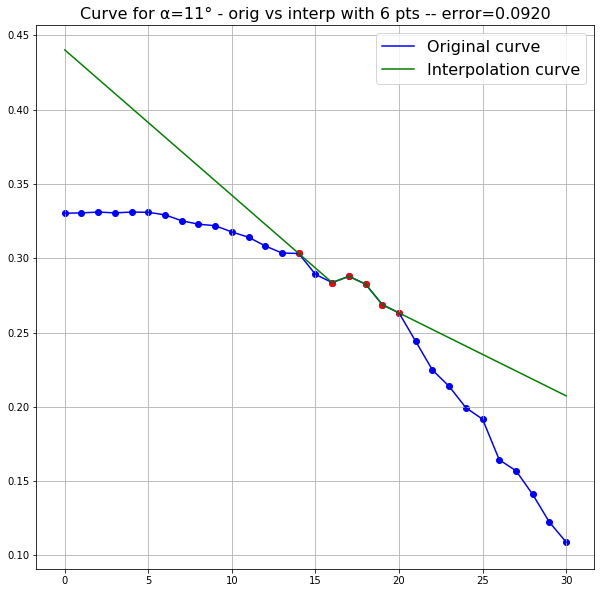

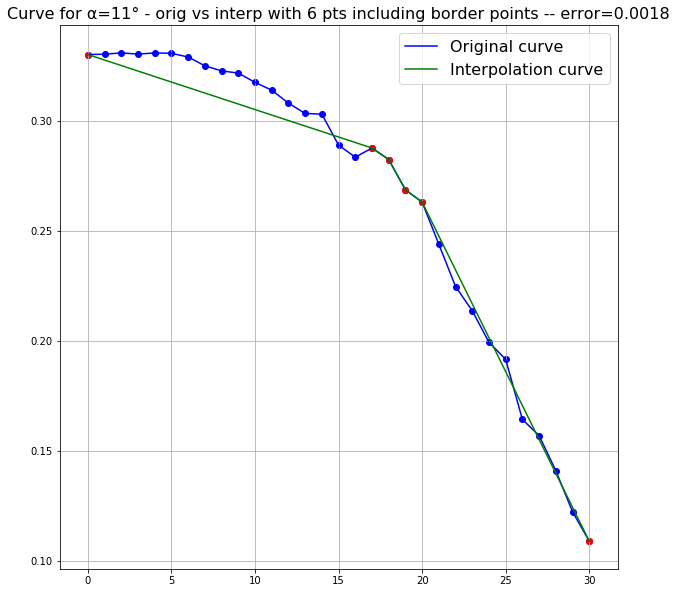

COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis


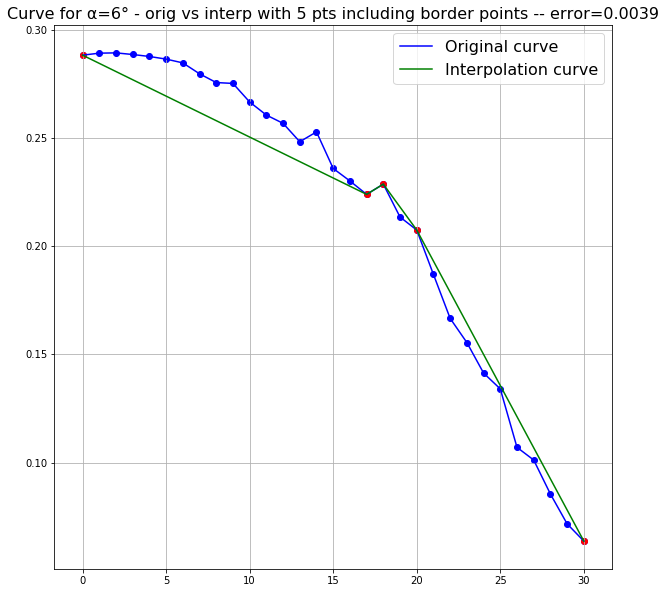

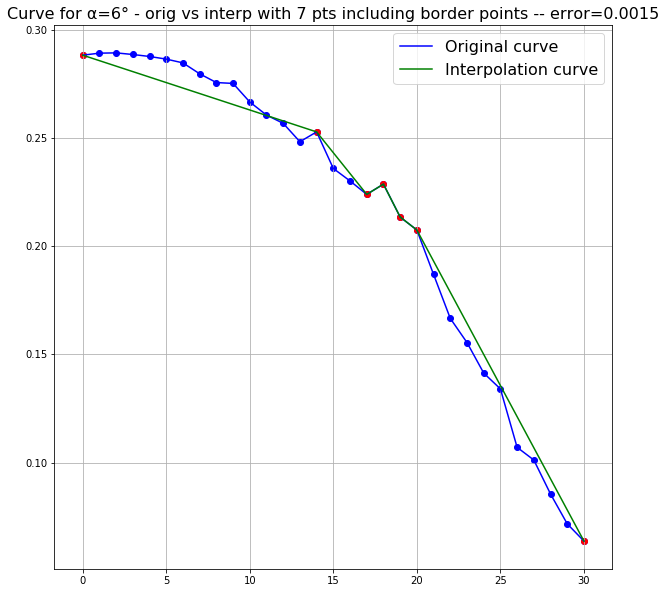

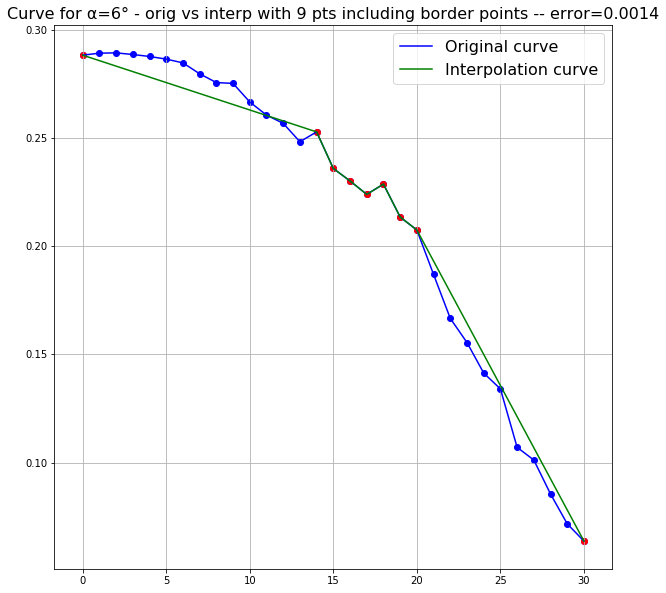

0.001421547002396101

In [11]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

X = np.transpose(np.copy(Flux))
print(X.shape)

def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

def compare_curve_with_interp(curve, n, top_n_function, title):
    top_n_angles = top_n_function(n)
    top_n_angles_indices = [get_index(alfa, c) for c in top_n_angles]
    plt.figure(figsize=(10, 10))
    x = alfa 
    baseline = X[curve, :] 
    plt.plot(x, baseline, c='b', label = 'Original curve')
    plt.scatter(x, baseline, c='b')
    x_ = top_n_angles
    y_ = X[curve, top_n_angles_indices]
    tck_ = interpolate.splrep(x_, y_, k=1)
    y = interpolate.splev(x, tck_) 
    error = np.sum((y - baseline)**2)
    plt.scatter(x_, y_, c='r')
    plt.grid()
    plt.plot(x, y, c='g', label = 'Interpolation curve')
    plt.title('%s -- error=%.4f' % (title, error), fontsize=16)
    plt.legend(loc='best', fontsize = 16)
    plt.show()
    return error

print('COMPARE INTERPOLATION WITH/ WITHOUT DEFINED BORDERS')
n = 6
curve = 11
compare_curve_with_interp(curve, n, get_top_angles, 
                                       'Curve for α=%d° - orig vs interp with %d pts' % (curve, n))
compare_curve_with_interp(curve, n, get_top_angles_bordered, 
                                       'Curve for α=%d° - orig vs interp with %d pts including border points' % (curve, n))


print('COMPARE INTERPOLATION WITH DIFF NUMBER of POINTS as basis')

n = 5
curve = 6
compare_curve_with_interp(curve, n, get_top_angles_bordered, 
                                       'Curve for α=%d° - orig vs interp with %d pts including border points' % (curve, n))
n = 7
compare_curve_with_interp(curve, n, get_top_angles_bordered, 
                                       'Curve for α=%d° - orig vs interp with %d pts including border points' % (curve, n))
n = 9
compare_curve_with_interp(curve, n, get_top_angles_bordered, 
                                       'Curve for α=%d° - orig vs interp with %d pts including border points' % (curve, n))


(13, 31)


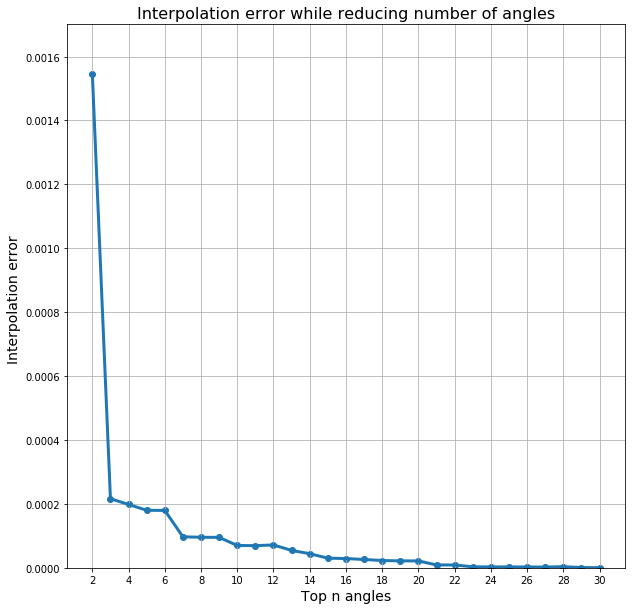

In [12]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

X = np.transpose(np.copy(Flux))
print(X.shape)

top_n = range(2, len(alfa))
errors = []
for n in top_n:
    top_n_angles = get_top_angles_bordered(n)
    top_n_angles_indices = [get_index(alfa, c) for c in top_n_angles]
    error = 0
    for curve in range(X.shape[0]):
        # baseline = y values obtained when interpolating with all ground truth points
        x = alfa 
        baseline = X[curve, :] 

        # interpolate with top_n_currents as basis 
        x_ = top_n_angles
        y_ = X[curve, top_n_angles_indices]
        tck_ = interpolate.splrep(x_, y_, k=1)
        y = interpolate.splev(x, tck_) 
        
        # error -- difference between baseline interp curve and current one
        error += np.sum((baseline - y)**2) /  baseline.shape[0]
    errors.append(error / X.shape[0])
            
plt.figure(figsize=(10, 10))
plt.xlabel('Top n angles', fontsize = 14)
plt.ylabel('Interpolation error ', fontsize = 14)
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(top_n))
plt.scatter(top_n, errors)
plt.plot(top_n, errors, linewidth=3)
plt.grid()
plt.title('Interpolation error while reducing number of angles', fontsize=16)
plt.savefig('SRM_output/errors_Spline_reducing_#angles.png', dpi = 200)
plt.show()
